# Credit Risk Assessment - Model Development
This notebook will implement a machine learning pipeline to predict loan status (credit risk). We'll use the insights from the EDA and experiment with various machine learning models.

# Import required libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading and Preprocessing

In [18]:
# Load the data
df = pd.read_csv('credit_risk_data.csv')

# Separate features and target variable
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# 2. Feature Engineering

We will engineer some new features based on domain knowledge:

1. Debt to Income Ratio: Loan amount divided by income.
2. Age to Employment Ratio: Person's age divided by employment length plus one.

In [19]:
from sklearn.compose import make_column_selector as selector

# Custom transformer for feature engineering before preprocessing
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_['debt_to_income'] = X_['loan_amnt'] / X_['person_income']
        X_['age_to_employment'] = X_['person_age'] / (X_['person_emp_length'] + 1)
        return X_

# 3. Preprocessing: Handling Categorical and Numerical Data
We'll create pipelines for preprocessing numerical and categorical data.

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature engineering occurs before preprocessing
fe_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer())
])

# Apply feature engineering
X_train_fe = fe_pipeline.fit_transform(X_train)
X_test_fe = fe_pipeline.transform(X_test)

# Preprocessing pipeline
numeric_features = X_train_fe.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train_fe.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Model Development and Training
We will develop models using Gradient Boosting and XGBoost to predict loan status. We'll also use feature selection and evaluate performance with classification metrics.

In [21]:
# Updated pipeline with preprocessor after feature engineering
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('model', GradientBoostingClassifier())
])

# Train the model
gb_pipeline.fit(X_train_fe, y_train)

# Make predictions
y_pred_gb = gb_pipeline.predict(X_test_fe)
y_pred_gb_proba = gb_pipeline.predict_proba(X_test_fe)[:, 1]

# Evaluation
print("Gradient Boosting Classifier Results:")
print(classification_report(y_test, y_pred_gb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_gb_proba))

Gradient Boosting Classifier Results:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5072
           1       0.88      0.64      0.74      1445

    accuracy                           0.90      6517
   macro avg       0.89      0.81      0.84      6517
weighted avg       0.90      0.90      0.90      6517

Confusion Matrix:
[[4944  128]
 [ 515  930]]
ROC AUC Score: 0.9066870285876458


# 5. Model 2: XGBoost
We'll use XGBoost and compare it with the Gradient Boosting model.

In [26]:
# Updated pipeline for XGBoost Classifier
xgb_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),  # Apply feature engineering first
    ('preprocessor', preprocessor),  # Preprocessor runs after feature engineering
    ('model', XGBClassifier(eval_metric='logloss'))
])

# Apply feature engineering before fitting the XGBoost pipeline
X_train_fe_xgb = fe_pipeline.fit_transform(X_train)
X_test_fe_xgb = fe_pipeline.transform(X_test)

# Train the XGBoost model
xgb_pipeline.fit(X_train_fe_xgb, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test_fe_xgb)
y_pred_xgb_proba = xgb_pipeline.predict_proba(X_test_fe_xgb)[:, 1]

# Evaluation
print("\nXGBoost Classifier Results:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_xgb_proba))


XGBoost Classifier Results:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5072
           1       0.95      0.74      0.83      1445

    accuracy                           0.93      6517
   macro avg       0.94      0.87      0.90      6517
weighted avg       0.94      0.93      0.93      6517

Confusion Matrix:
[[5020   52]
 [ 374 1071]]
ROC AUC Score: 0.9493619901105738


# 6. Model Comparison and Cross-Validation
We will compare models using cross-validation.

In [27]:
# Cross-validation for model comparison
# Here we need to ensure the feature engineering step is consistent
models = [
    ('Gradient Boosting', gb_pipeline),
    ('XGBoost', xgb_pipeline)
]

# Apply feature engineering to the full dataset for cross-validation
X_fe = fe_pipeline.fit_transform(X)

for name, model in models:
    scores = cross_val_score(model, X_fe, y, cv=5, scoring='roc_auc')
    print(f"{name} - Mean ROC AUC: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Gradient Boosting - Mean ROC AUC: 0.890 (+/- 0.041)
XGBoost - Mean ROC AUC: 0.924 (+/- 0.037)


# 7. Feature Importance
We'll extract and visualize feature importance from the Gradient Boosting model.

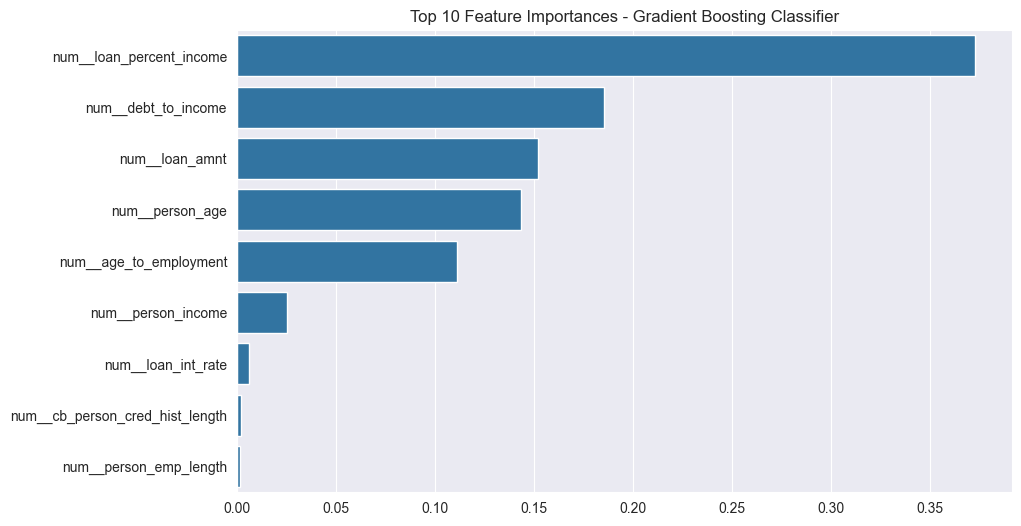

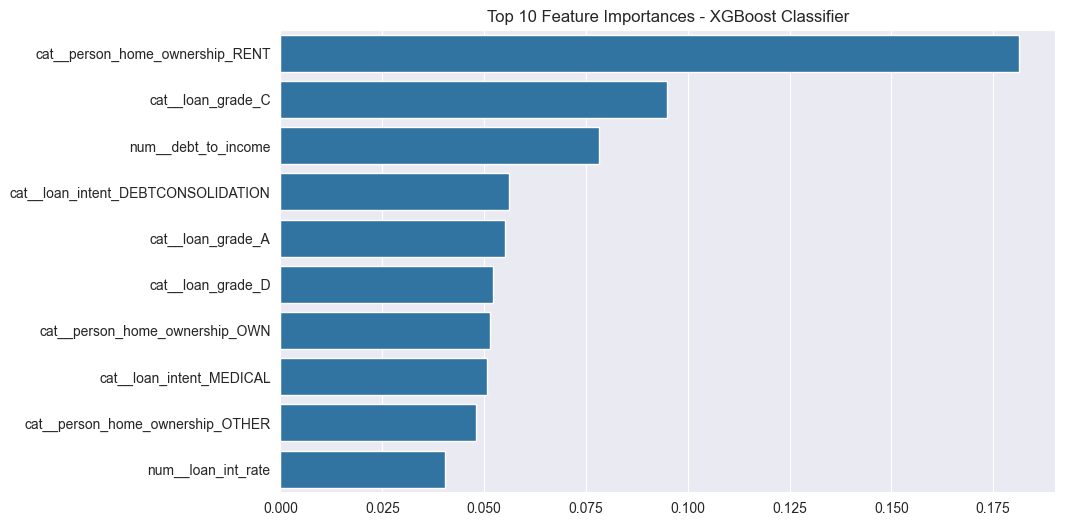

In [28]:
# Feature importance for Gradient Boosting Classifier
feature_importance_gb = gb_pipeline.named_steps['model'].feature_importances_
feature_names_gb = (gb_pipeline.named_steps['preprocessor'].get_feature_names_out().tolist() +
                    ['debt_to_income', 'age_to_employment'])

# Sort feature importances in descending order
indices_gb = np.argsort(feature_importance_gb)[::-1]

# Plot top 10 features for Gradient Boosting Classifier
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_gb[indices_gb][:10], y=np.array(feature_names_gb)[indices_gb][:10])
plt.title('Top 10 Feature Importances - Gradient Boosting Classifier')
plt.show()

# Feature importance for XGBoost Classifier (optional)
feature_importance_xgb = xgb_pipeline.named_steps['model'].feature_importances_
feature_names_xgb = (xgb_pipeline.named_steps['preprocessor'].get_feature_names_out().tolist() +
                     ['debt_to_income', 'age_to_employment'])

# Sort feature importances in descending order for XGBoost
indices_xgb = np.argsort(feature_importance_xgb)[::-1]

# Plot top 10 features for XGBoost Classifier
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_xgb[indices_xgb][:10], y=np.array(feature_names_xgb)[indices_xgb][:10])
plt.title('Top 10 Feature Importances - XGBoost Classifier')
plt.show()